In [1]:

import os 
os.chdir('/lustre/scratch/kiviaho/dbitseq_atac/')

# Data crunch
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import squidpy as sq

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde,zscore

from scipy import stats

sns.set_theme(style='white')
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4fhr_sfx because the default path (/run/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Data download

In [2]:
archr_export_dir = '/lustre/scratch/kiviaho/dbitseq_atac/archr_outs/test_project/export/'

barcode_location_mapping_df = pd.read_csv('spatial_location_barcodes.csv')

# Metadata
cell_metadata = pd.read_csv(archr_export_dir+'cell_metadata.csv',index_col=0)
cell_metadata.index = [i.split('#')[1] for i in cell_metadata.index]

# Gene counts
gene_scores = pd.read_csv(archr_export_dir+'gene_scores.csv',index_col=0)
gene_scores.columns = [i.split('#')[1] for i in gene_scores.columns]

# Extract the location "coordinates" NOTE: Barcode 1 defines the y-axis, barcode 2 defines the x-axis
barcode_location_mapping_df['x_coord'] = [s[1].strip('B') for s in barcode_location_mapping_df['Sample_ID'].str.split('_')]
barcode_location_mapping_df['y_coord'] = [s[0].strip('A') for s in barcode_location_mapping_df['Sample_ID'].str.split('_')]

# Map coordinates on the barcodes 
cell_metadata['x_coord'] = cell_metadata.index.map(barcode_location_mapping_df[['index','x_coord']].set_index('index').to_dict()['x_coord']).astype(int)
cell_metadata['y_coord'] = cell_metadata.index.map(barcode_location_mapping_df[['index','y_coord']].set_index('index').to_dict()['y_coord']).astype(int)

# Create an inverted y_coord for squidpy
cell_metadata['y_coord_inverted'] = cell_metadata['y_coord'].max() - cell_metadata['y_coord'] + 1


In [3]:
def save_peak_calls_to_bed(df,savefile_name):
    df = df.reset_index()
    df = df[['seqnames','start','end','index']]
    df.to_csv(savefile_name,index=False,header=False,sep='\t')

peak_calls = pd.read_csv(archr_export_dir + 'peak_counts/peaks.csv',index_col=0)
save_peak_calls_to_bed(peak_calls,'sample_A_peak_calls.bed')

### Quality control plots

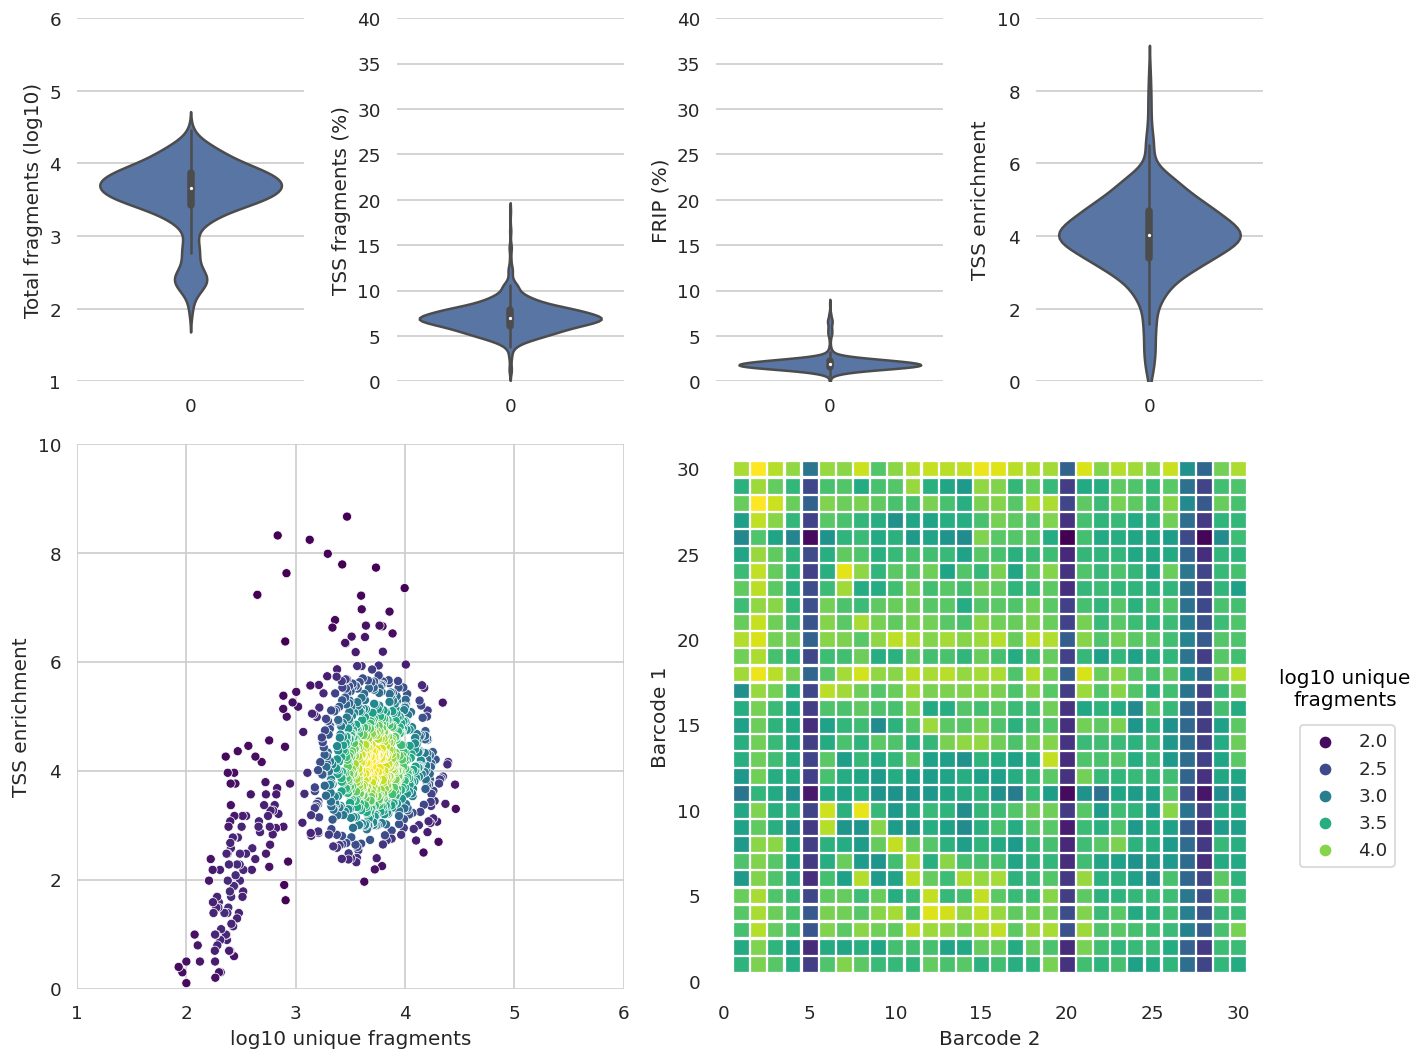

In [18]:
## Format plotting data
plot_df = cell_metadata.copy()
plot_df["log_nFrags"] = np.log10(plot_df['nFrags'])
plot_df["TSS_pct"] = plot_df['ReadsInTSS'] / plot_df['nFrags'] * 100

# Set the theme
sns.set_theme(style='whitegrid')

# Create a figure with a custom grid layout
fig = plt.figure(figsize=(12, 9), dpi=120)
gs = GridSpec(2, 4, height_ratios=[4, 6])

# First row of violin plots
ax1 = fig.add_subplot(gs[0, 0])
sns.violinplot(np.log10(plot_df['nFrags']), ax=ax1)
ax1.set_ylabel('Total fragments (log10)')
ax1.set_ylim(1, 6)

ax2 = fig.add_subplot(gs[0, 1])
sns.violinplot(plot_df['TSS_pct'], ax=ax2)
ax2.set_ylabel('TSS fragments (%)')
ax2.set_ylim(0, 40)

ax3 = fig.add_subplot(gs[0, 2])
sns.violinplot(plot_df['FRIP'] * 100, ax=ax3)
ax3.set_ylabel('FRIP (%)')
ax3.set_ylim(0, 40)

ax4 = fig.add_subplot(gs[0, 3])
sns.violinplot(plot_df['TSSEnrichment'], ax=ax4)
ax4.set_ylabel('TSS enrichment')
ax4.set_ylim(0, 10)

# Calculate the point density
xy = np.vstack([plot_df["log_nFrags"], plot_df["TSSEnrichment"]])
kernel = gaussian_kde(xy)(xy)

# Second row of scatter plots
ax5 = fig.add_subplot(gs[1, 0:2])
sns.scatterplot(
    data=plot_df,
    x="log_nFrags",
    y="TSSEnrichment",
    c=kernel,
    #linewidth=0.2,
    #edgecolor='black',
    cmap="viridis",
    s=30,
    ax=ax5,
)
ax5.set_xlim(1, 6)
ax5.set_ylim(0, 10)
ax5.set_xlabel('log10 unique fragments')
ax5.set_ylabel('TSS enrichment')

sns.set_theme(style='white')
ax6 = fig.add_subplot(gs[1, 2:4])
sns.scatterplot(
    data=plot_df,
    x='x_coord',
    y='y_coord',
    hue='log_nFrags',
    marker='s',
    palette='viridis',
    s=90,
    ax=ax6,
)

ax6.set_xlabel('Barcode 2')
ax6.set_ylabel('Barcode 1')

ax6.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left')
ax6.text(1.15, 0.52, 'log10 unique\nfragments', fontsize=12, color='black', ha='center', transform=ax6.transAxes)

sns.despine(left=True, bottom=True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


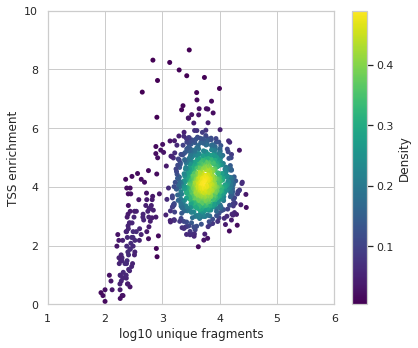

In [5]:
## Format plotting data
plot_df = cell_metadata.copy()
plot_df["log_nFrags"] = np.log10(plot_df['nFrags'])
plot_df["TSS_pct"] = plot_df['ReadsInTSS'] / plot_df['nFrags'] * 100

# Set the theme
sns.set_theme(style='whitegrid')

fig, ax5 = plt.subplots(figsize=(6,5))
# Calculate the point density
xy = np.vstack([plot_df["log_nFrags"], plot_df["TSSEnrichment"]])
kernel = gaussian_kde(xy)(xy)

# Create the scatter plot
scatter = ax5.scatter(
    plot_df["log_nFrags"],
    plot_df["TSSEnrichment"],
    c=kernel,
    cmap="viridis",
    s=25,
    linewidth=0
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax5)
cbar.set_label('Density')

ax5.set_xlim(1, 6)
ax5.set_ylim(0, 10)
ax5.set_xlabel('log10 unique fragments')
ax5.set_ylabel('TSS enrichment')

# Adjust layout
plt.tight_layout()

plt.savefig('./plots/test_sample_log10_fragments_TSS_enrichment_scatter.pdf')
# Show the plot
plt.show()


### Spatial region activity score plots

In [6]:
gene_modules = pd.read_excel('./spatial_region_markers.xlsx')
top_n = 500

module_score_df = pd.DataFrame(index=gene_scores.columns,columns = gene_modules.columns)
for mod in gene_modules:
    signature = gene_modules[mod].dropna()[:top_n] # Extract the signature
    signature = signature[signature.isin(gene_scores.index.tolist())] # Intersect with genes present in the gene_scores df
    print(f'{mod} signature length: {len(signature)}')
    score = gene_scores.loc[signature].mean(axis=0) # Calculate the gene score mean across all the genes in the signature
    module_score_df[mod] = score # Populate the score df with the sum
    


Tumor signature length: 466
Luminal signature length: 487
Basal signature length: 46
Club signature length: 445
Immune signature length: 479
Endothelium signature length: 137
Fibroblast signature length: 286
Muscle signature length: 278


In [7]:
# Create an AnnData object from the expression data
adata = ad.AnnData(X=module_score_df.values, obs=cell_metadata, var=pd.DataFrame(index=module_score_df.columns))

# Add spatial coordinates to the AnnData object
adata.obsm['spatial'] = cell_metadata[['x_coord', 'y_coord_inverted']].values
adata.uns['spatial'] = {}
adata.uns['spatial']['foo'] = {}
adata.uns['spatial']['foo']['images'] = {}
adata.uns['spatial']['foo']['images']['hires'] = np.ones([900,900,3]) # Generate a placeholder image for plotting
adata.uns['spatial']['foo']["scalefactors"] = {"tissue_hires_scalef": 29, "spot_diameter_fullres": 1}


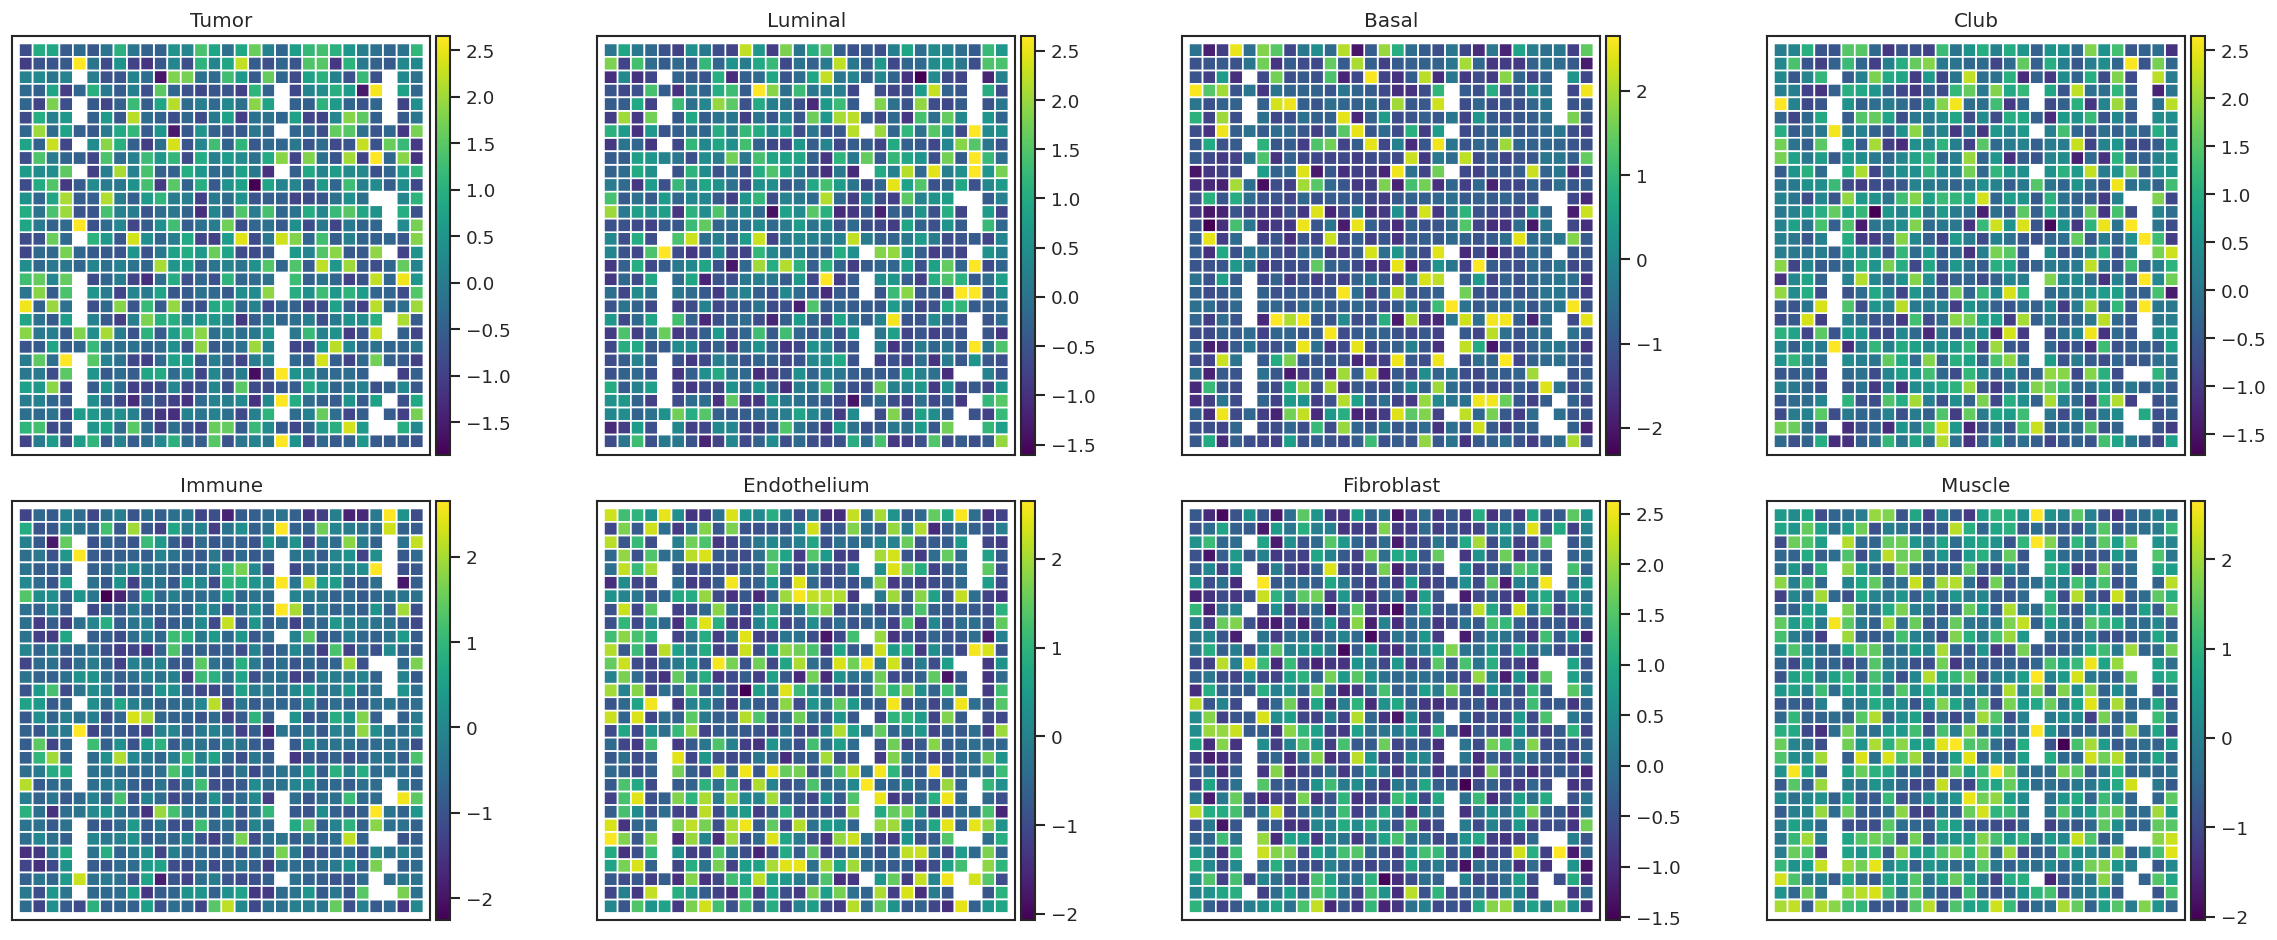

In [14]:
adata_zscores = adata.copy()
adata_zscores.X = pd.DataFrame(adata_zscores.X).apply(zscore,axis=1)

# Create a 2 by 4 grid for the plots
fig, axes = plt.subplots(2, 4, figsize=(20, 8),dpi=120)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each module score in the grid
for i, mod in enumerate(module_score_df.columns):
    sq.pl.spatial_scatter(adata_zscores, color=mod, size=1, shape='square', cmap='viridis', ax=axes[i])
    axes[i].set_title(mod)

    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [9]:
# Moran's I spatial autocorrelation
# If the 

sq.gr.spatial_neighbors(adata,coord_type='grid',n_neighs=4,n_rings=2)
sq.gr.spatial_autocorr(adata)
adata.uns['moranI'].sort_values('I',ascending=False)

,I,pval_norm,var_norm,pval_norm_fdr_bh
Muscle,0.025509,0.028915,0.000197,0.231321
Luminal,0.007026,0.280973,0.000197,0.469938
Endothelium,0.004257,0.351003,0.000197,0.469938
Club,0.000679,0.449200,0.000197,0.469938
Basal,-0.002171,0.469938,0.000197,0.469938
Immune,-0.002956,0.447727,0.000197,0.469938
Tumor,-0.015943,0.145304,0.000197,0.387477
Fibroblast,-0.020894,0.079322,0.000197,0.317288


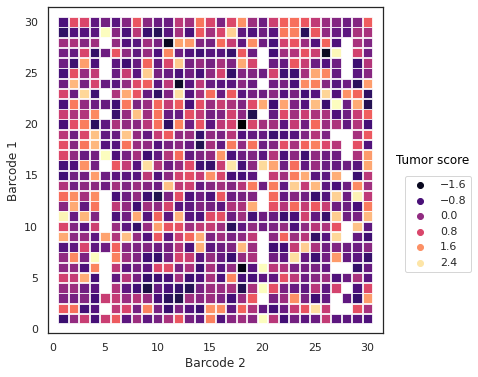

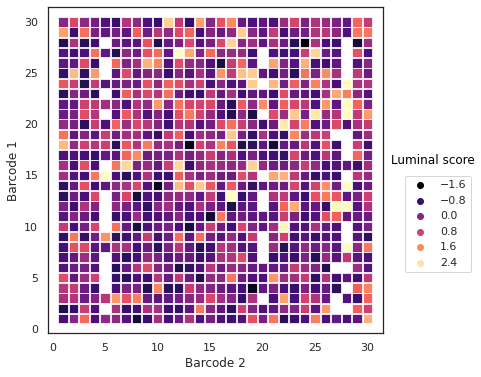

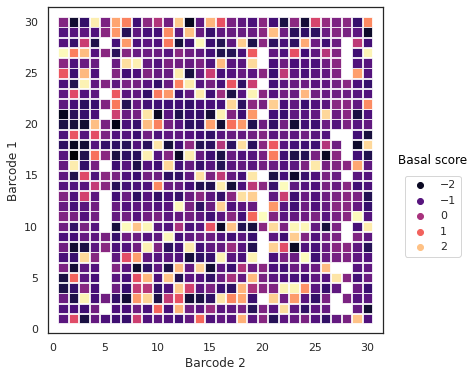

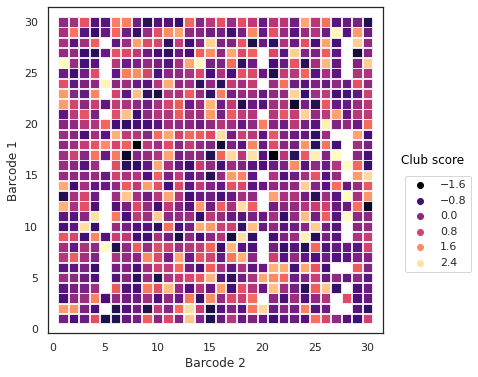

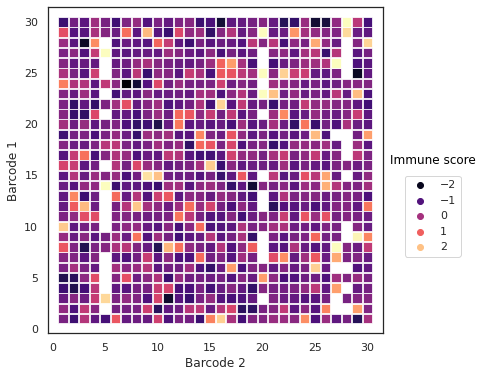

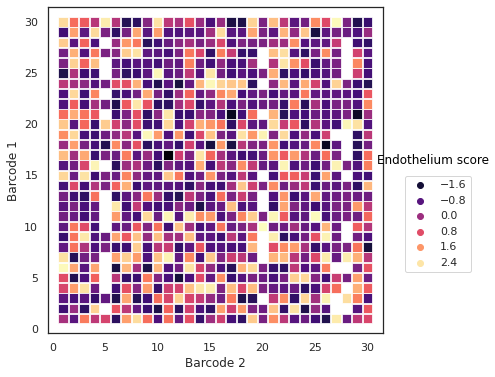

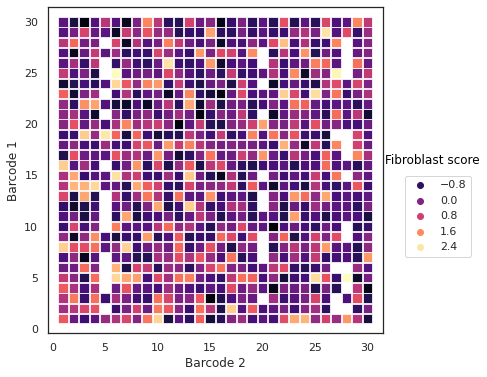

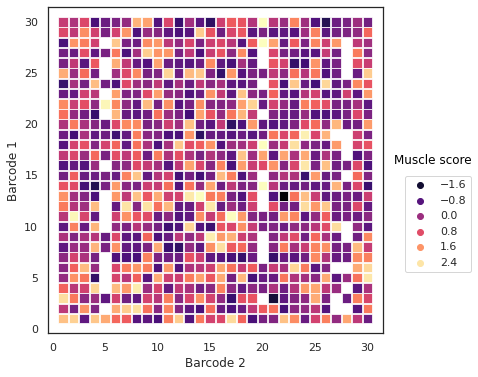

In [11]:

module_score_df_zscore = module_score_df.apply(zscore,axis=1)

plot_df = pd.concat([cell_metadata,module_score_df_zscore],axis=1)
for gene in module_score_df.columns:
    # Drop zero gene scores

    sns.set_theme(style='white')
    fig,ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(
        data=plot_df,
        x='x_coord',
        y='y_coord',
        hue=gene,
        marker='s',
        palette='magma',
        s=90,
        ax=ax,
    )

    ax.set_xlabel('Barcode 2')
    ax.set_ylabel('Barcode 1')

    ax.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left')
    ax.text(1.15, 0.52, f'{gene} score', fontsize=12, color='black', ha='center', transform=ax.transAxes)

    plt.show()

### Individual activity score plots

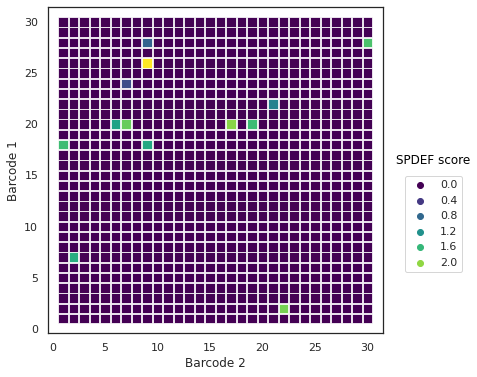

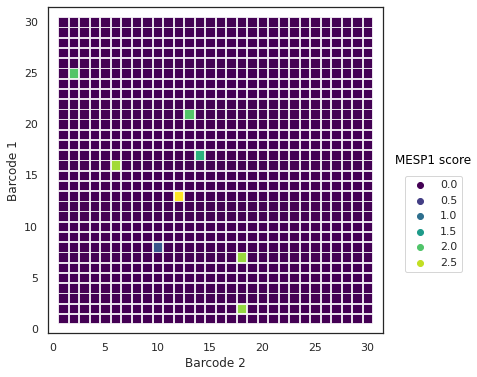

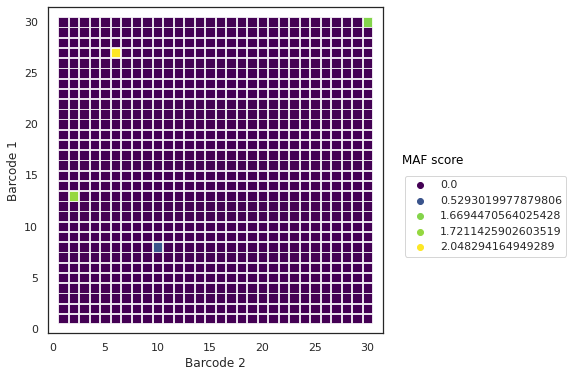

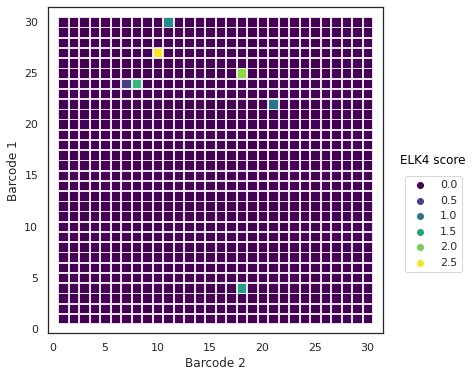

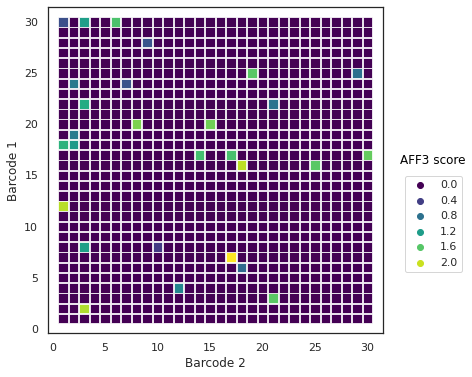

In [13]:
top_genes = gene_scores.mean(axis=1).sort_values(ascending=False)[:10].index.tolist() # Take the genes with the highest mean score
top_genes = gene_scores.var(axis=1).sort_values(ascending=False)[:10].index.tolist() # Take the genes with the highest score variance

# Is there any preservation in the spatial structure?

#top_genes = ['FOXA1','KLF5','ELF3']

top_genes = ['SPDEF','MESP1','MAF','ELK4','AFF3']
# Remove genes with 0 score across all locations
gene_scores_filtered = gene_scores.loc[(gene_scores.max(axis=1) != 0)].T
# Log-transform
gene_scores_filtered = np.log10(gene_scores_filtered+1)
plot_df = pd.concat([cell_metadata,gene_scores_filtered],axis=1)


for gene in top_genes:
    # Drop zero gene scores

    sns.set_theme(style='white')
    fig,ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(
        data=plot_df,
        x='x_coord',
        y='y_coord',
        hue=gene,
        marker='s',
        palette='viridis',
        s=90,
        ax=ax,
    )

    ax.set_xlabel('Barcode 2')
    ax.set_ylabel('Barcode 1')

    ax.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left')
    ax.text(1.15, 0.52, f'{gene} score', fontsize=12, color='black', ha='center', transform=ax.transAxes)

    plt.show()